In [116]:
%%latex

$$\textbf{A brief summary of what has been done}$$
$$\\$$

$\mathbf{1.}$ In the beginning we construct ISM transmition function which depends on $z$ and $\lambda$ (not redshifted).
In the code below it is named $$\textit{F_IMS}$$

$$\\$$

$\mathbf{2.}$ In the next cell we choose a filter to work with (in our case it is f160w) and build its 
transmition function $$\textit{F_filter}$$

$$\\$$

$\mathbf{3.}$ Inside the following cell we face for the first time the source data for the fake hst image simulation and 
thereafter extract and derived from it another important quantities such as masses, times, metallicities and current
redshift. It is worth to mention that we specified a spherical region (25 kpc) with the highest mass density 
at the center in lieu of working with the full box.

$$\\$$

$\mathbf{4.}$ Next there are two functions for convenience. To understand what they stand for see its description.

$$\\$$

$\mathbf{5.}$ Now we enter the main simulation process. First, let's break down simple but important calculations here:

$$\\$$

5.1 The angular size of our specified region is
\begin{equation}
\theta \thinspace [milli-arcsec] = \frac{2 \times R \thinspace  [kpc]}{D_{a} [Mpc]} \times (radians \thinspace to \thinspace milli-arcsec
                                                                  \thinspace coef)
= \frac{2 \times 25 \thinspace  [pc] \times 10^{3}}{D_{a} [pc] \times 10^{6}} \times 206265 \times 10^{3},
\end{equation}
where $D_{a}$ - angular distance, $2R$ - diameter of the sphere

$$\\$$

5.2 Then we want milli-arcsecond/pixel = 60/1 ratio. Therefore, number of pixels along each axis is simply $nbins = 
\theta \thinspace [milli-arcsec] / 60$

$$\\$$

$\mathbf{6.}$ The next step is to work with fluxes. Let's consider an arbitrary pixel in our mesh. 
$$\\$$

6.1 Initially, from look-up tables
we have SED in [ (Solar luminosity units) / (Solar mass units) / Hz ] for specific time, metallicity and wavelength
$$\\$$
6.2 Then from our source data we know the amount of mass concentrated in the pixel. So we multiply SED by this
amount of mass $m$[in solar mass units].
$$\\$$
6.3 Because these calculations for a specific $\lambda$ and $z$ we can also multiply ($SED \times m$) by transmition 
function throughout the ISM (F_IMS).

6.4 Now we can compute total flux:
\begin{equation}
\mathbf{F} \thinspace \left[ \thinspace \frac{erg}{s \thinspace cm{2}} \thinspace \right]
\thinspace =  \thinspace \frac{ \int\limits_{0}^{+\infty} L_{\nu} \times F_{filter} \times L_{\odot} d\nu}{4\pi D_{L}^{2}}, \quad
\text{where} \thinspace L_{\odot} = 3.828 \times 10^{33}, \thinspace L_{\nu} = SED \times m \times F_{ISM}
\thinspace [\thinspace (Solar  \thinspace luminosity  \thinspace units) \thinspace /  \thinspace Hz \thinspace ]
\end{equation} 
and $D_{L}$ is the luminosity distance [Mpc].

$$\\$$

$\mathbf{7.}$ Finally, only two things left to do. We should add noize to our image and then convolve it with Point 
spread function for f160w filter.

$$\\$$
7.1 We get noise data from another image. Therefore, before adding the noise to our image we need to make sure
that the units of two term in the sum are the same. Actually, it turns out, that there are not. Thus, let's convert 
Flux $\mathbf{F}$.
$$\\$$
Noise data zero point = 25.94. 
$$\\$$
$\mathbf{F}$ in $\thinspace \left[ \thinspace \frac{erg}{s \thinspace cm{2}} \thinspace \right]
$ corresponds to zero point = -48.6.
$$\\$$
\begin{equation}
\kappa \thinspace \thinspace (from \thinspace \mathbf{F} \thinspace to \thinspace noise) \thinspace = \thinspace 10^{0.4(25.94 + 48.6)} = 6.5464 \times 10^{29}
\end{equation}
$$\\$$
\begin{equation}
\mathbf{\tilde{F}} = \mathbf{F} \times \kappa + noise \thinspace \thinspace  data
\end{equation}

$$\\$$
$$\\$$

From now on we 

$$\\$$





<IPython.core.display.Latex object>

In [2]:
%matplotlib notebook

import yt
import glob
import numpy              as np
import healpy             as hp
import cosmolopy          as cp
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import scipy.ndimage      as ndimage

from scipy                import signal
from scipy.interpolate    import interp1d
from scipy.interpolate    import interp2d
from scipy.interpolate    import RegularGridInterpolator
from scipy                import integrate
from astropy.io           import fits
from astropy              import wcs
from mpl_toolkits.mplot3d import Axes3D


<IPython.core.display.Javascript object>


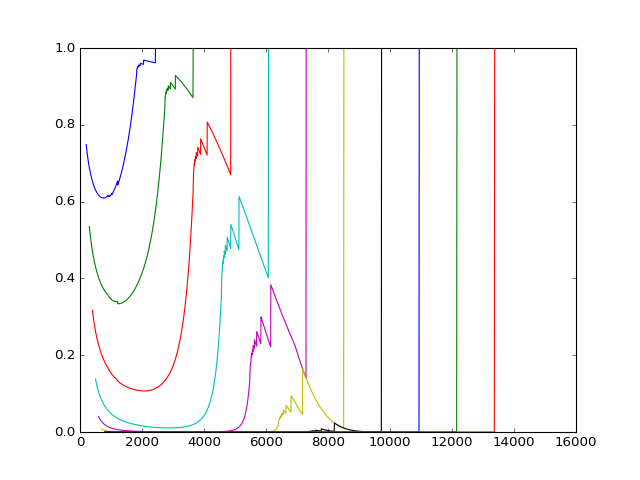

In [3]:
'''

Transmition function throughout the ISM, which depends on redshift z and radiation wavelength

'''

table = np.loadtxt('table_transmition_ISM.dat')
lam_rest   = table[1:,0]
z          = table[0,1:]
trans_coef = table[1:,1:]

F_IMS = interp2d(z, lam_rest, trans_coef)

plt.figure(0)
for i in range(1,11):
    plt.plot(lam_rest*(1+i),F_IMS(i,lam_rest))

    

In [4]:
'''

To get the filter of interest (f160w), its transmition function, the lowest and the highest wavelength

'''

temp_filters = open('data/FILTER.RES.latest', 'r')
filters = []
filters_names = []
first = True

for line in temp_filters:

    if line[0] == ' ':
        if not first:
            filters.append(np.array(temp))

        first = False
        filters_names.append(line.split())
        temp = []

    else:
        temp.append(np.array(line.split()).astype('float'))

filters.append(np.array(temp))
filters = np.array(filters)

for ifilt in range(len(filters_names)):
    if filters_names[ifilt][1] == 'hst/wfc3/IR/f160w.dat':
        filter_b = np.array([filters[ifilt][:,1],filters[ifilt][:,2]])
        filter_b = np.transpose(filter_b)

F_filter = interp1d(filter_b[:,0], filter_b[:,1],fill_value=0.0,bounds_error=False)
left,right = np.min(filter_b[:,0]),np.max(filter_b[:,0])

yt : [WARNING  ] 2016-08-24 19:42:50,813 DeltaDC != 0, which implies auni != abox.  Be sure you understand which expansion parameter is appropriate for your use! (Gnedin, Kravtsov, & Rudd 2011)
yt : [INFO     ] 2016-08-24 19:42:50,829 Parameters: current_time              = 683058841.16758 yr
yt : [INFO     ] 2016-08-24 19:42:50,830 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2016-08-24 19:42:50,831 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2016-08-24 19:42:50,832 Parameters: domain_right_edge         = [ 32.  32.  32.]
yt : [INFO     ] 2016-08-24 19:42:50,833 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2016-08-24 19:42:50,834 Parameters: current_redshift          = 7.6209655546310415
yt : [INFO     ] 2016-08-24 19:42:50,835 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2016-08-24 19:42:50,835 Parameters: omega_matter              = 0.3035999834537506
yt : [INFO     ] 2016-08-24 19:42:5

{}


yt : [INFO     ] 2016-08-24 19:42:55,351 Loading field plugins.
yt : [INFO     ] 2016-08-24 19:42:55,352 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-08-24 19:42:55,353 Loaded astro (15 new fields)
yt : [INFO     ] 2016-08-24 19:42:55,354 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-08-24 19:42:55,355 Loaded fluid (63 new fields)
yt : [INFO     ] 2016-08-24 19:42:55,356 Loaded fluid_vector (95 new fields)
yt : [INFO     ] 2016-08-24 19:42:55,357 Loaded geometric (111 new fields)
yt : [INFO     ] 2016-08-24 19:42:55,358 Loaded local (111 new fields)
yt : [INFO     ] 2016-08-24 19:42:55,359 Loaded magnetic_field (119 new fields)
yt : [INFO     ] 2016-08-24 19:42:55,359 Loaded my_plugins (119 new fields)
yt : [INFO     ] 2016-08-24 19:42:55,360 Loaded species (121 new fields)
yt : [INFO     ] 2016-08-24 19:43:27,346 Created 32 chunks for ARTIO
yt : [INFO     ] 2016-08-24 19:43:30,718 Max Value is 7.75725e-21 at 21.1767578125000000 15.0615234375000000 12.713867187

<IPython.core.display.Javascript object>


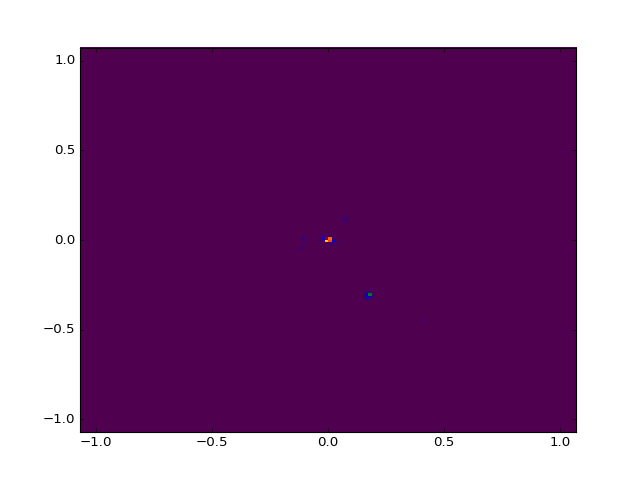

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-1.07021527, -1.05594573, -1.04167619, -1.02740665, -1.01313712,
        -0.99886758, -0.98459804, -0.97032851, -0.95605897, -0.94178943,
        -0.9275199 , -0.91325036, -0.89898082, -0.88471129, -0.87044175,
        -0.85617221, -0.84190268, -0.82763314, -0.8133636 , -0.79909406,
        -0.78482453, -0.77055499, -0.75628545, -0.74201592, -0.72774638,
        -0.71347684, -0.69920731, -0.68493777, -0.67066823, -0.6563987 ,
        -0.64212916, -0.62785962, -0.61359009, -0.59932055, -0.58505101,
        -0.57078147, -0.55651194, -0.5422424 , -0.52797286, -0.51370333,
        -0.49943379, -0.48516425, -0.47089472, -0.45662518, -0.44235564,
        -0.42808611, -0.41381657, -0.39954703, -0.3852775

In [5]:
'''

To load and thereafter calculate all the necessary data for simulation

''' 

muf_list = glob.glob("./drt/muv.bin*")          
files = glob.glob("./rei05B_a0*/rei05B_a*.art")    
pf = yt.load(files[1])
simulation_name = files[1][-18:-4]

lam_list = np.zeros(len(muf_list))
lookup = np.zeros([len(muf_list), 188, 22])

for i in range(len(muf_list)):

    f = open(muf_list[i])
    header = f.readline()
    f.close()
    d1 = header.split()[0]
    d2 = header.split()[1]
    lam_list[i] = float(header.split()[2])

    data = np.genfromtxt(muf_list[i], skip_header=1)
    lookup[i, :, :] = data[1:,1:]

dx = data[0, 1:]
dy = data[1:, 0] 

data = pf.sphere('max', (25.0, "kpc"))

x = np.array(data[('STAR', 'POSITION_X')] - data.center[0])
y = np.array(data[('STAR', 'POSITION_Y')] - data.center[1])
z = np.array(data[('STAR', 'POSITION_Z')] - data.center[2])

m = data[('STAR', 'MASS')].in_units('msun')
met = data[('STAR', 'METALLICITY_SNIa')].in_units('Zsun') + data[('STAR', 'METALLICITY_SNII')].in_units('Zsun')
t = np.log10(data[('STAR', 'age')].in_units('yr'))
redshift = pf.current_redshift
lam_list *= (1+redshift)

plt.figure(1)
plt.hist2d(x,y,150,range=np.array([(-data.radius, data.radius), (-data.radius, data.radius)]))


In [6]:
def flux_integration_over_freq(flux_nu,lam):

    '''
    
    flux_nu: monochromatic flux from a distant object at redshift z (pixelized and written in P-matrix)
    units [erg/s/cm2/Hz]

    lam: redshifted wavelengths
    units [angstrom]

    mtr_int: total flux in P-matrix (through filter bandwidth)
    units [erg/s/cm^2]
        

    '''
    
    nu = 2.99792458e10/(lam/1e8)

    flux_total = np.zeros_like(flux_nu[:,:,0])

    for i in range(0,len(flux_nu[:,0,0])):
        for j in range(0,len(flux_nu[0,:,0])):

            flux_total[i,j] = integrate.trapz( flux_nu[i,j,::-1] * F_filter(lam[::-1]), nu[::-1]) / integrate.trapz(F_filter(lam[::-1]), nu[::-1])

    np.savetxt('flux_emit_' + simulation_name +'.dat',flux_total,fmt='%1.5e')

    return flux_total

In [7]:
def filter_bandwidth(a,b,x):
    
    global lambdas

    '''

    Initially we have SED tables for vast range of wavelengths and this function picks out those wavelengths, which
    are in filter bandwidth.

    '''

    position_in_lam_array = []
    lambdas               = []

    for i in range(0,len(x)):
        if (a<=x[i] and x[i]<=b):
            if(F_filter(x[i])>=1e-3):
                position_in_lam_array.append(i)
                lambdas.append(x[i])

    lambdas = np.array(lambdas)
    position_in_lam_array = np.array(position_in_lam_array)

    indices = np.argsort(lambdas)

    return position_in_lam_array[indices]

number of pixels 75


<IPython.core.display.Javascript object>


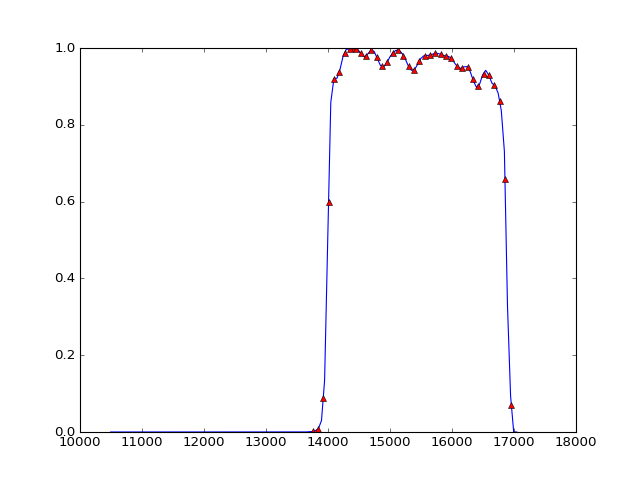

In [8]:
'''

The main procedure to create a fake HST image

nbins: number of pixels in our image (both for x axix and y axix [z axis])

ang_dist: angular distance
units [Mpc]

lum_dist: luminosity distance
units [Mpc]

filter_lam: lambdas, which are in the filter range
units [Angstoms]

theta_milliarcsec: selected region as it is seen by HST
units [milli-arcseconds]

We define the following resolution for the fake image: 60 milli-arcsecond/pixel

'''


ang_dist = cp.distance.angular_diameter_distance(redshift, **cp.fidcosmo)
lum_dist = cp.distance.luminosity_distance(redshift, **cp.fidcosmo)

theta_arcsec = ( 2 * 25.0 * 1e3 ) / ( ang_dist * 1e6  ) * ( 206265.0 )
nbins =  int(theta_arcsec * 1/0.13)  # 0.13 arcsec / pixel is wfc3 camera IR channel resolution 

print('number of pixels', nbins)

filter_lam = filter_bandwidth(left,right,lam_list)

plt.figure(2)
plt.plot(filter_b[:,0],F_filter(filter_b[:,0]),'b-')
plt.plot(lambdas,F_filter(lambdas),'r^')




1 out of 39 13750.4400596 1595.0
2 out of 39 13836.6497152 1605.0
3 out of 39 13922.8593707 1615.0
4 out of 39 14009.0690263 1625.0
5 out of 39 14095.2786818 1635.0
6 out of 39 14181.4883374 1645.0
7 out of 39 14267.6979929 1655.0
8 out of 39 14353.9076485 1665.0
9 out of 39 14414.2544073 1672.0
10 out of 39 14457.3592351 1677.0
11 out of 39 14526.3269596 1685.0
12 out of 39 14612.5366151 1695.0
13 out of 39 14698.7462706 1705.0
14 out of 39 14784.9559262 1715.0
15 out of 39 14871.1655817 1725.0
16 out of 39 14957.3752373 1735.0
17 out of 39 15043.5848928 1745.0
18 out of 39 15129.7945484 1755.0
19 out of 39 15216.0042039 1765.0
20 out of 39 15302.2138595 1775.0
21 out of 39 15388.423515 1785.0
22 out of 39 15474.6331706 1795.0
23 out of 39 15560.8428261 1805.0
24 out of 39 15647.0524817 1815.0
25 out of 39 15733.2621372 1825.0
26 out of 39 15819.4717927 1835.0
27 out of 39 15905.6814483 1845.0
28 out of 39 15991.8911038 1855.0
29 out of 39 16078.1007594 1865.0
30 out of 39 16164.31041

<IPython.core.display.Javascript object>


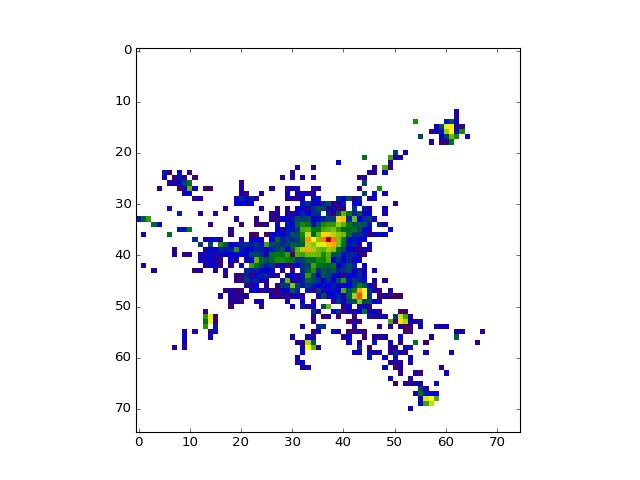

/home/maryhallow/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10


In [9]:
image = np.zeros([nbins, nbins, len(filter_lam)])

index = 0

for i in filter_lam:

    print(index+1, 'out of',len(filter_lam),lam_list[i],lam_list[i]/(1+redshift))

    interp = interp2d(dx, dy, lookup[i, :, :])
    Flux = np.zeros_like(m)

    for j in range(len(m)):

        L =  F_IMS(redshift,lam_list[i]/(1+redshift))[0] * interp(met[j], t[j])[0] * m[j] * 3.828e33  # L_(1+z)nu in erg/s/Hz
        Flux[j] = (1+redshift) * L / (4 * np.pi * np.power(lum_dist*3.0857e18*1e6,2))

    xedges = np.linspace(-data.radius, data.radius, nbins+1)
    yedges = np.linspace(-data.radius, data.radius, nbins+1)

    H, X, Y = np.histogram2d(x, y, bins=(xedges, yedges), weights = Flux)
    image[:, :, index] = np.rot90(H)

    index += 1

flux_total = flux_integration_over_freq(image,lam_list[filter_lam])

plt.figure(3)
plt.imshow(np.log10(flux_total), interpolation='nearest')

0.0426464107466


CTYPE1  ='RA---TAN'                                                              [astropy.io.fits.card]
CTYPE2  ='DEC--TAN'                                                              [astropy.io.fits.card]
DATE-OBS='2009-12-13'                                                            [astropy.io.fits.card]
TIME-OBS='21:23:07'                                                              [astropy.io.fits.card]
ROOTNAME='ibcj03kdq                                                              [astropy.io.fits.card]
TARGNAME='OMEGACEN                                                               [astropy.io.fits.card]
FILTER1 =                                                                        [astropy.io.fits.card]
FILTER2 =                                                                        [astropy.io.fits.card]


<IPython.core.display.Javascript object>


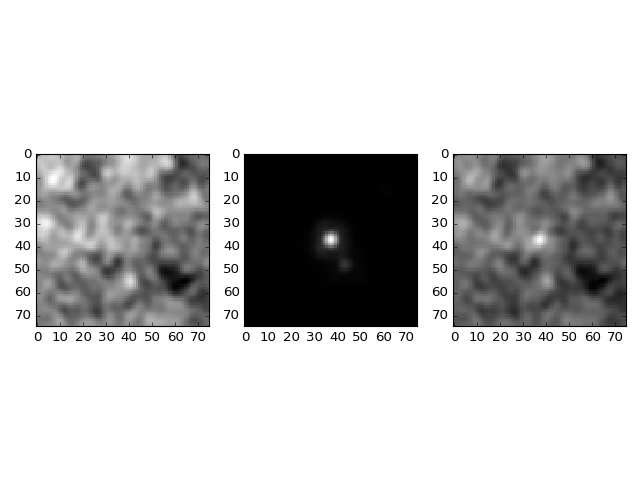

In [10]:
'''

Point spread function (from WFC3 PSFs)
(check out http://www.stsci.edu/hst/wfc3/analysis/PSF for more information)

Noise (from HLS GOODS-S region)
(check out https://archive.stsci.edu/prepds/hlf/ for more information)

'''

pixels_with_noise = fits.open('hlsp_hlf_hst_wfc3-60mas_goodss_f160w_v1.0_sci.fits')[0].data[25000-15258:25000-15258+nbins,10326:10326+nbins]
zero_point = 25.94
coeff = 10 ** (0.4 * (zero_point + 48.6) )
flux_with_noise = flux_total*coeff + pixels_with_noise
PSF = fits.open('psf_wfc3ir_f160w.fits')[0].data
flux_with_noise_psf = signal.fftconvolve(flux_with_noise, PSF, mode='same')
print(np.max(flux_with_noise_psf))

np.savetxt('f160w_filter.dat',flux_with_noise_psf,fmt='%1.5e')


plt.figure(4)
ax1 = plt.subplot(1,3,1)
plt.imshow(signal.fftconvolve(pixels_with_noise, PSF, mode='same'), interpolation='nearest',cmap=plt.cm.gray)

ax1 = plt.subplot(1,3,2)
plt.imshow(signal.fftconvolve(flux_total, PSF, mode='same'), interpolation='nearest',cmap=plt.cm.gray)

ax1 = plt.subplot(1,3,3)
plt.imshow(flux_with_noise_psf, interpolation='nearest',cmap=plt.cm.gray)

plt.tight_layout()

In [22]:


print('redshift = ',redshift)
galaxy_m   = []
galaxy_met = []
galaxy_t   = []

for i in range(0,len(m)):
    if((x[i]*x[i]+y[i]*y[i])<=0.04*0.04):
        galaxy_m.append(m[i])
        galaxy_t.append(t[i])
        galaxy_met.append(met[i])
        
galaxy_m = np.array(galaxy_m)    

print(len(m))
print(len(galaxy_m))
print('')
print('max/min mass', np.max(galaxy_m),np.min(galaxy_m))
print('max/min met', np.max(galaxy_met),np.min(galaxy_met))
print('max/min time', np.max(galaxy_t),np.min(galaxy_t))
print('')
print('max noise',np.max(pixels_with_noise))
print('max source', np.max(flux_total*coeff))
print(len(lam_list))


redshift =  7.6209655546310415
38272
23511

max/min mass 39969.3888886 5995.39683548
max/min met 0.0809331677865 7.84586109908e-28
max/min time 8.64562047564 5.01763000517

max noise 0.0104022
max source 0.0924641104338
561


In [25]:
galaxy_flux = np.zeros(len(lam_list))
index = 0
for i in np.argsort(lam_list):
    
    print(index,lam_list[i])
    interp = interp2d(dx, dy, lookup[i, :, :],bounds_error=False,fill_value=0.0)
    for j in range(0,len(galaxy_m)):
        galaxy_flux[index] += interp(galaxy_met[j], galaxy_t[j])[0] * galaxy_m[j]
        
    index += 1


0 7801.97382694
1 7888.18348249
2 7974.39313803
3 8060.60279358
4 8146.81244913
5 8233.02210467
6 8319.23176022
7 8405.44141577
8 8491.65107131
9 8577.86072686
10 8664.0703824
11 8750.28003795
12 8836.4896935
13 8922.69934904
14 9008.90900459
15 9095.11866014
16 9181.32831568
17 9267.53797123
18 9353.74762677
19 9439.95728232
20 9526.16693787
21 9612.37659341
22 9698.58624896
23 9784.79590451
24 9871.00556005
25 9957.2152156
26 10043.4248711
27 10129.6345267
28 10215.8441822
29 10302.0538378
30 10388.2634933
31 10474.4731489
32 10560.6828044
33 10646.89246
34 10733.1021155
35 10819.3117711
36 10905.5214266
37 10991.7310822
38 11077.9407377
39 11164.1503932
40 11250.3600488
41 11336.5697043
42 11422.7793599
43 11508.9890154
44 11595.198671
45 11681.4083265
46 11767.6179821
47 11853.8276376
48 11940.0372932
49 12026.2469487
50 12112.4566043
51 12198.6662598
52 12284.8759153
53 12371.0855709
54 12431.4323298
55 12474.5371576
56 12543.504882
57 12629.7145375
58 12715.9241931
59 12802.13384

<IPython.core.display.Javascript object>


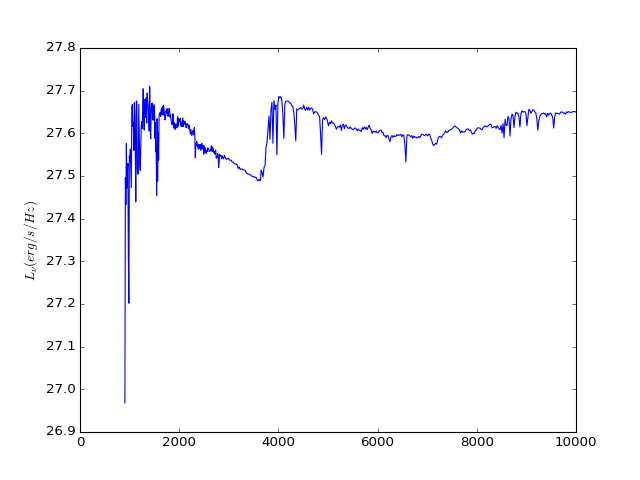


1.17783596799e+43
galaxy total flux 3.07690e+09 [in Solar lum units]

1.33004490264e+42
0.0336616106543


In [27]:
g_flux = galaxy_flux*3.828e33
plt.figure(10)
plt.ylabel('$L_{\\nu}(erg/s/Hz)$')
lamb = lam_list[np.argsort(lam_list)]
plt.plot(lamb/(1+redshift),np.log10(g_flux),'b-')


nu = 2.99792458e10/(lamb/1e8/(1+redshift))
galaxy_total_flux = integrate.trapz( g_flux[::-1] , nu[::-1])
galaxy_filter_flux = integrate.trapz( g_flux[::-1]*F_filter(lamb[::-1]), nu[::-1])
freq_int  = integrate.trapz( F_filter(lamb[::-1]), nu[::-1])
print('')
print(galaxy_total_flux)
print('galaxy total flux %1.5e [in Solar lum units]' % (galaxy_total_flux/3.828e33))
print('')
print(galaxy_filter_flux)
print(galaxy_filter_flux/(4 * np.pi * np.power(lum_dist*3.0857e18*1e6,2))/freq_int * coeff * (1+redshift))
